### HW11_zz1598
## Assignment 2 - CLUSTERING BUSINESS

## Goal: cluster NYC businesses establishment over time
### DATA
**1. [Census Business data](http://www.census.gov/econ/cbp/download/)**
download census data for businesses by ZIP code. <br/>
**2. [NYC Zipcode shape file](http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981)**
This website is currently down. I will read from the geojson file attached directly. 

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np

#import geopandas as  gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import seaborn
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")  
    os.environ['PUIDATA'] = '/home/cusp/zz1598/PUIdata'
    
print (os.environ['PUIDATA'] ) #print the path of desired directory PUIDATA

/home/cusp/zz1598/PUIdata


## 1. Download Census Business Data
1994 - 2014 (1993 and 2015 are currently not available)

### ---- before downloading please read----
#### I downloaded the zip files into my PUIDATA folder, keeping their original names. If you have already had those data, please skip this step and load the data directly.

In [ ]:
# Download data 1994-1999
for y in (94, 100):
    os.system('curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp' + str(y) + 'totals.zip')
    os.system('mv zbp' + str(y) + 'totals.zip ' + os.getenv('PUIDATA')) # move to PUIDATA directory

In [ ]:
# Download data 2000-2001
for y in (0, 2):
    os.system('curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0' + str(y) + 'totals.zip')
    os.system('mv zbp0' + str(y) + 'totals.zip ' + os.getenv('PUIDATA')) 

In [ ]:
# 2002-2009
for y in (2, 10):
    os.system('curl -O ftp://ftp.census.gov/econ200' + str(y) + '/CBP_CSV/zbp' + str(y) + 'totals.zip')
    os.system('mv zbp0' + str(y) + 'totals.zip ' + os.getenv('PUIDATA'))

In [ ]:
 2010-2014
for y in (10, 15):
    os.system('curl -O ftp://ftp.census.gov/econ20' + str(y) + '/CBP_CSV/zbp' + str(y) + 'totals.zip')
    os.system('mv zbp' + str(y) + 'totals.zip ' + os.getenv('PUIDATA'))

In [ ]:
# Alternative method using wget
# Example:
#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

## ----------------------------------------

## 2. Load NYC Zipcodes Shape File

In [4]:
# read geojson file using geopandas
zc_shape = GeoDataFrame.from_file("nyc-zip-code-tabulation-areas-polygons.geojson")
# select four columns
zc_shape = zc_shape[['postalCode', 'borough', 'PO_NAME', 'geometry']]
# Change column name 
zc_shape = zc_shape.rename(columns={'postalCode': "zipcode"})
# Convert the zipcodes to numbers
zc_shape.zipcode = zc_shape['zipcode'].apply(pd.to_numeric)

zc_shape.head(3)

,zipcode,borough,PO_NAME,geometry
0,11372,Queens,Jackson Heights,POLYGON ((-73.86942457284175 40.74915687096787...
1,11004,Queens,Glen Oaks,POLYGON ((-73.71068374074007 40.75004039450917...
2,11040,Queens,New Hyde Park,POLYGON ((-73.70098278625547 40.73889569923034...


In [5]:
# Unique Zipcodes in NYC
num_all = len(zc_shape.zipcode)
num_uni = len(zc_shape.zipcode.unique())

print 'There are', num_all, 'zipcodes'
print 'There are', num_uni, 'unique zipcodes'

There are 262 zipcodes
There are 247 unique zipcodes


In [6]:
# Check dupilicated zipcodes
zc_dup = zc_shape.zipcode.value_counts()
zc_dup[zc_dup > 1]

10004    4
11693    4
10464    3
11370    2
10047    2
11096    2
10463    2
10035    2
11231    2
10196    2
Name: zipcode, dtype: int64

In [7]:
# Check how the other columns of duplicated zipcodes look like
dup = zc_shape[zc_shape.zipcode.isin(zc_dup[zc_dup > 1].index)]
dup.head()

,zipcode,borough,PO_NAME,geometry
42,10463,Bronx,Bronx,POLYGON ((-73.92064636455856 40.88723759323028...
44,10464,Bronx,Bronx,POLYGON ((-73.81538709262482 40.88939453228316...
47,10463,Manhattan,Bronx,"POLYGON ((-73.915441048975 40.87559096359296, ..."
55,10464,Bronx,Bronx,POLYGON ((-73.77200435481511 40.85711639255333...
56,10464,Bronx,Bronx,POLYGON ((-73.79234936771036 40.85607454194248...


#### Note: From the table above, the geometries corresponding to the same zipcode are mostly difference. However, as later on we will need to merge census business data based on zipcodes, I will use only the unique zipcodes to improve the accuracy.

In [8]:
# Now I keep 247 unique zipcodes
zc_shape2 = zc_shape.drop_duplicates(subset='zipcode', keep='first', inplace=False)
zc_shape2.shape

(247, 4)

## 3. Merge Census Business Data to Zipcodes

In [9]:
# years we have for business data
year = ['94', '95', '96', '97', '98', '99',\
        '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',\
        '11', '12', '13', '14']

In [10]:
# Create a new dataframe ready to add merged columns
CBus = zc_shape2.copy()

# Merge census business data files by reading from zip files directly 
for yr in year:
    # zip file names
    filepath = os.getenv('PUIDATA') + str('/zbp' + yr + 'totals.zip')
    # load the data
    zf = zipfile.ZipFile(filepath)
    df = pd.read_csv(zf.open('zbp'+ yr + 'totals.txt'))
    
    # convert targed columns to UPPER case (for columns ZIP, EST)
    df.columns = df.columns.map(str.upper)
    BE = df[['EST','ZIP']]
    # Merge the business data files one by one
    CBus = CBus.merge(BE, how='left', left_on='zipcode', right_on='ZIP')
    CBus.drop('ZIP', axis=1, inplace=True)  #remove the "ZIP" column
    # rename the column
    col = str('bEsmt' + yr)
    CBus = CBus.rename(columns={'EST': col})
    
CBus.head(3)

,zipcode,borough,PO_NAME,geometry,bEsmt94,bEsmt95,bEsmt96,bEsmt97,bEsmt98,bEsmt99,...,bEsmt05,bEsmt06,bEsmt07,bEsmt08,bEsmt09,bEsmt10,bEsmt11,bEsmt12,bEsmt13,bEsmt14
0,11372,Queens,Jackson Heights,POLYGON ((-73.86942457284175 40.74915687096787...,1229.0,1236.0,1292.0,1309.0,1351.0,1376.0,...,1539.0,1527.0,1545.0,1538.0,1572.0,1629.0,1647.0,1724.0,1759.0,1768.0
1,11004,Queens,Glen Oaks,POLYGON ((-73.71068374074007 40.75004039450917...,194.0,188.0,176.0,192.0,194.0,186.0,...,225.0,226.0,238.0,227.0,233.0,229.0,222.0,241.0,241.0,250.0
2,11040,Queens,New Hyde Park,POLYGON ((-73.70098278625547 40.73889569923034...,1422.0,1414.0,1335.0,1344.0,1344.0,1350.0,...,1441.0,1454.0,1488.0,1503.0,1475.0,1494.0,1488.0,1510.0,1539.0,1534.0



## 4. Standardize Census Business data

In [11]:
CBus2 = CBus.copy()
# Calculte mean and standard deviation of each row (for time series we standarize(by row) instead of whiten(by columns))
row_mean = CBus2.ix[:,4:].mean(axis=1)
row_std = CBus2.ix[:,4:].std(axis=1)
CBus2.ix[:,4:] = CBus2.ix[:,4:].apply(lambda x: (x- row_mean) / row_std, axis=0)

In [12]:
CBus2.head(3)

,zipcode,borough,PO_NAME,geometry,bEsmt94,bEsmt95,bEsmt96,bEsmt97,bEsmt98,bEsmt99,...,bEsmt05,bEsmt06,bEsmt07,bEsmt08,bEsmt09,bEsmt10,bEsmt11,bEsmt12,bEsmt13,bEsmt14
0,11372,Queens,Jackson Heights,POLYGON ((-73.86942457284175 40.74915687096787...,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,11004,Queens,Glen Oaks,POLYGON ((-73.71068374074007 40.75004039450917...,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,11040,Queens,New Hyde Park,POLYGON ((-73.70098278625547 40.73889569923034...,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662


In [13]:
# Drop NaN for performing clustering algorithm
CBus3 = CBus2.dropna()
CBus3.shape  # Now we have 230 valid rows

(230, 25)

## 5. KMeans Clustering

### by trying 5 and 4 clusters, I believe 3 clusters would be more appropriate for our data sets

In [14]:
# Perform Kmeans clustering
X0 = np.asarray(CBus3.ix[:,4:])
km = KMeans(n_clusters=3, random_state=222)
res_cluster = km.fit(X0)
klabels = res_cluster.labels_   #labels in of the 3 clusters
kcenters = res_cluster.cluster_centers_

In [15]:
klabels # view the labels

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2,
       1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [16]:
kcenters # view the centers 
# I will pick the centers of 2000 and 2010 business data points to plot the clustering results

array([[-1.45453635, -1.32720483, -1.18104676, -0.97950617, -0.86286443,
        -0.77866139, -0.65391911, -0.58377652, -0.215906  , -0.06282572,
         0.13501094,  0.23924345,  0.28009851,  0.43586002,  0.52337509,
         0.60879721,  0.81738894,  0.965474  ,  1.13464029,  1.37546159,
         1.58489722],
       [-0.16124704,  0.18966919,  0.38999436,  0.60928548,  0.74190734,
         0.74198805,  1.03125247,  0.87550347,  0.29213247,  0.27784866,
         0.43049536,  0.20522517,  0.10413939, -0.27184374, -0.46553599,
        -0.66019058, -0.83102847, -1.00782598, -0.90173243, -0.80662969,
        -0.78340749],
       [ 1.28044751,  0.85592637,  0.35099355, -0.05040952, -0.21100748,
         0.12608719, -0.20185289, -0.35392901, -0.7806202 , -0.96273026,
        -0.66869539, -0.46400397, -0.48787462, -0.16385465, -0.22570545,
        -0.04573668,  0.04257926,  0.09906381,  0.5292572 ,  0.52487912,
         0.80718611]])

### Plot Kmeans results and centers
#### 1.I pick 2000 and 2010 data points to show the clustering labels and centers on a 2 dimensional plane (x, and y axis)


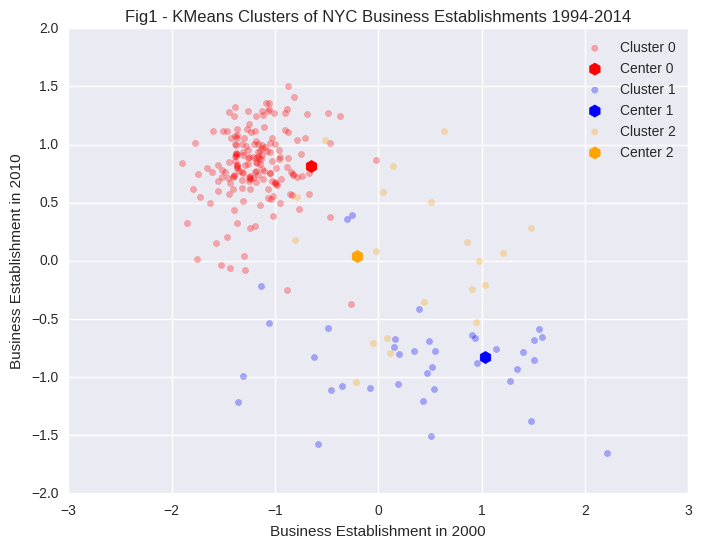

In [69]:
colors = ['red', 'blue', 'orange']

pl.figure(figsize=(8, 6))

for l in range(0, 3): # 3 labels
    pl.scatter(CBus3[klabels == l].ix[:,6], \
               CBus3[klabels == l].ix[:,-5], \
              color = colors[l], alpha=0.3, label='Cluster %d'%l)
    pl.scatter(kcenters[l][6], kcenters[l][-5],\
              marker='h', s=80, color=colors[l], label='Center %d'%l)

pl.title("Fig1 - KMeans Clusters of NYC Business Establishments 1994-2014")    
pl.xlabel('Business Establishment in 2000')
pl.ylabel('Business Establishment in 2010')
pl.legend(fontsize=10, loc='best')

**figure 1**: The plot shows the Kmeans clustering results performed on the NYC business establishment over 1994 to 2014. I plot the data points of 2000 and 2010 to show the cluster labels and cluster centers on a two dimensional plane. 
From the plot, the data points in different clusters are labeled with different color. Most of the points surround the cluster centers in a close distance, while there are some sparse points far from the centers.

#### 2. I use all the timestamps to plot the time series of businesss establishments from 1994-2014 by zipcode clusters

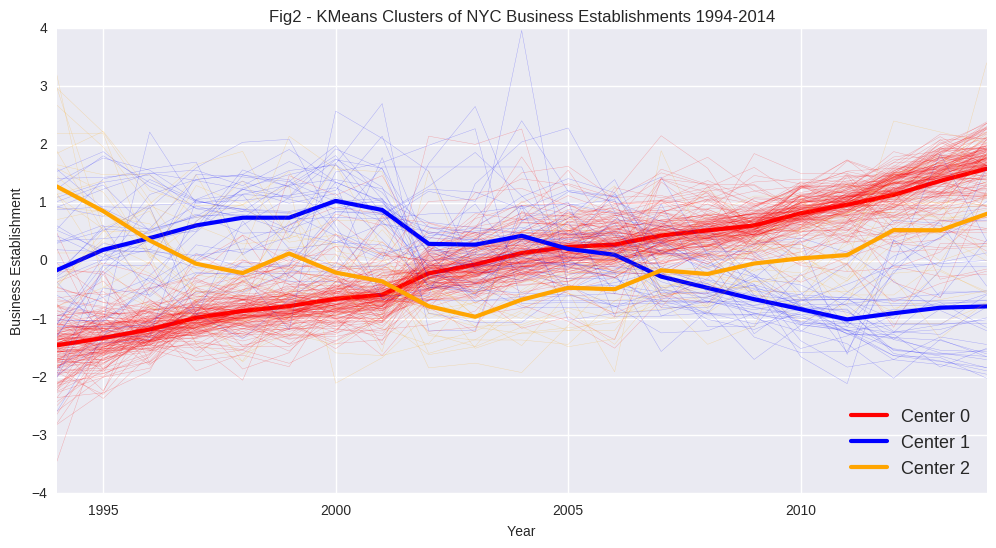

In [70]:
# Time Series plot for business of clustered zipcodes using 1994-2014 Timestamps
# We use the same colors for clusters as the above
pl.figure(figsize=(12, 6))

for l in range(0, 3): # 3 labels
    for zc in CBus3[klabels == l].index:  # zipcodes in the specific cluster
        pl.plot(np.arange(1994,2015,1), CBus3.ix[zc,4:].values, color = colors[l], alpha=0.3, linewidth=0.3)
    pl.plot(np.arange(1994,2015,1), kcenters[l], color=colors[l], linewidth=3, label='Center %d'%l)

pl.xlim(1994, 2014)
pl.title("Fig2 - KMeans Clusters of NYC Business Establishments 1994-2014")    
pl.xlabel('Year', fontsize=10)
pl.ylabel('Business Establishment', fontsize=10)
pl.legend(fontsize=13, loc='best')

**Figure 2**: Time Series plot of kmeans clustering centers and business data from 1994 to 2014 shows the trends of business establishment changes in each cluster over time. From the lines of the cluster centers, it can be seen that businesses in zipcodes that belongs to cluster 0(in red) kept increasing steadily, and all the data points were concentrated along the line. Businesses in cluster 2(orange lines) increased after a drop, where those in cluster 1(blue lines) started decreasing in 2000 after an increase from 1994. Data points in clusters 1 and 2 are not as concentrated as those in cluster 0. <br/>

The findings are quite consistant with what we discovered in Figure 1, using only the 2000 and 2010 data.

## 6. Hierarchical Clustering

In [71]:
# Pick "ward" as linkage method
Z = linkage(CBus3.ix[:,4:], 'ward')

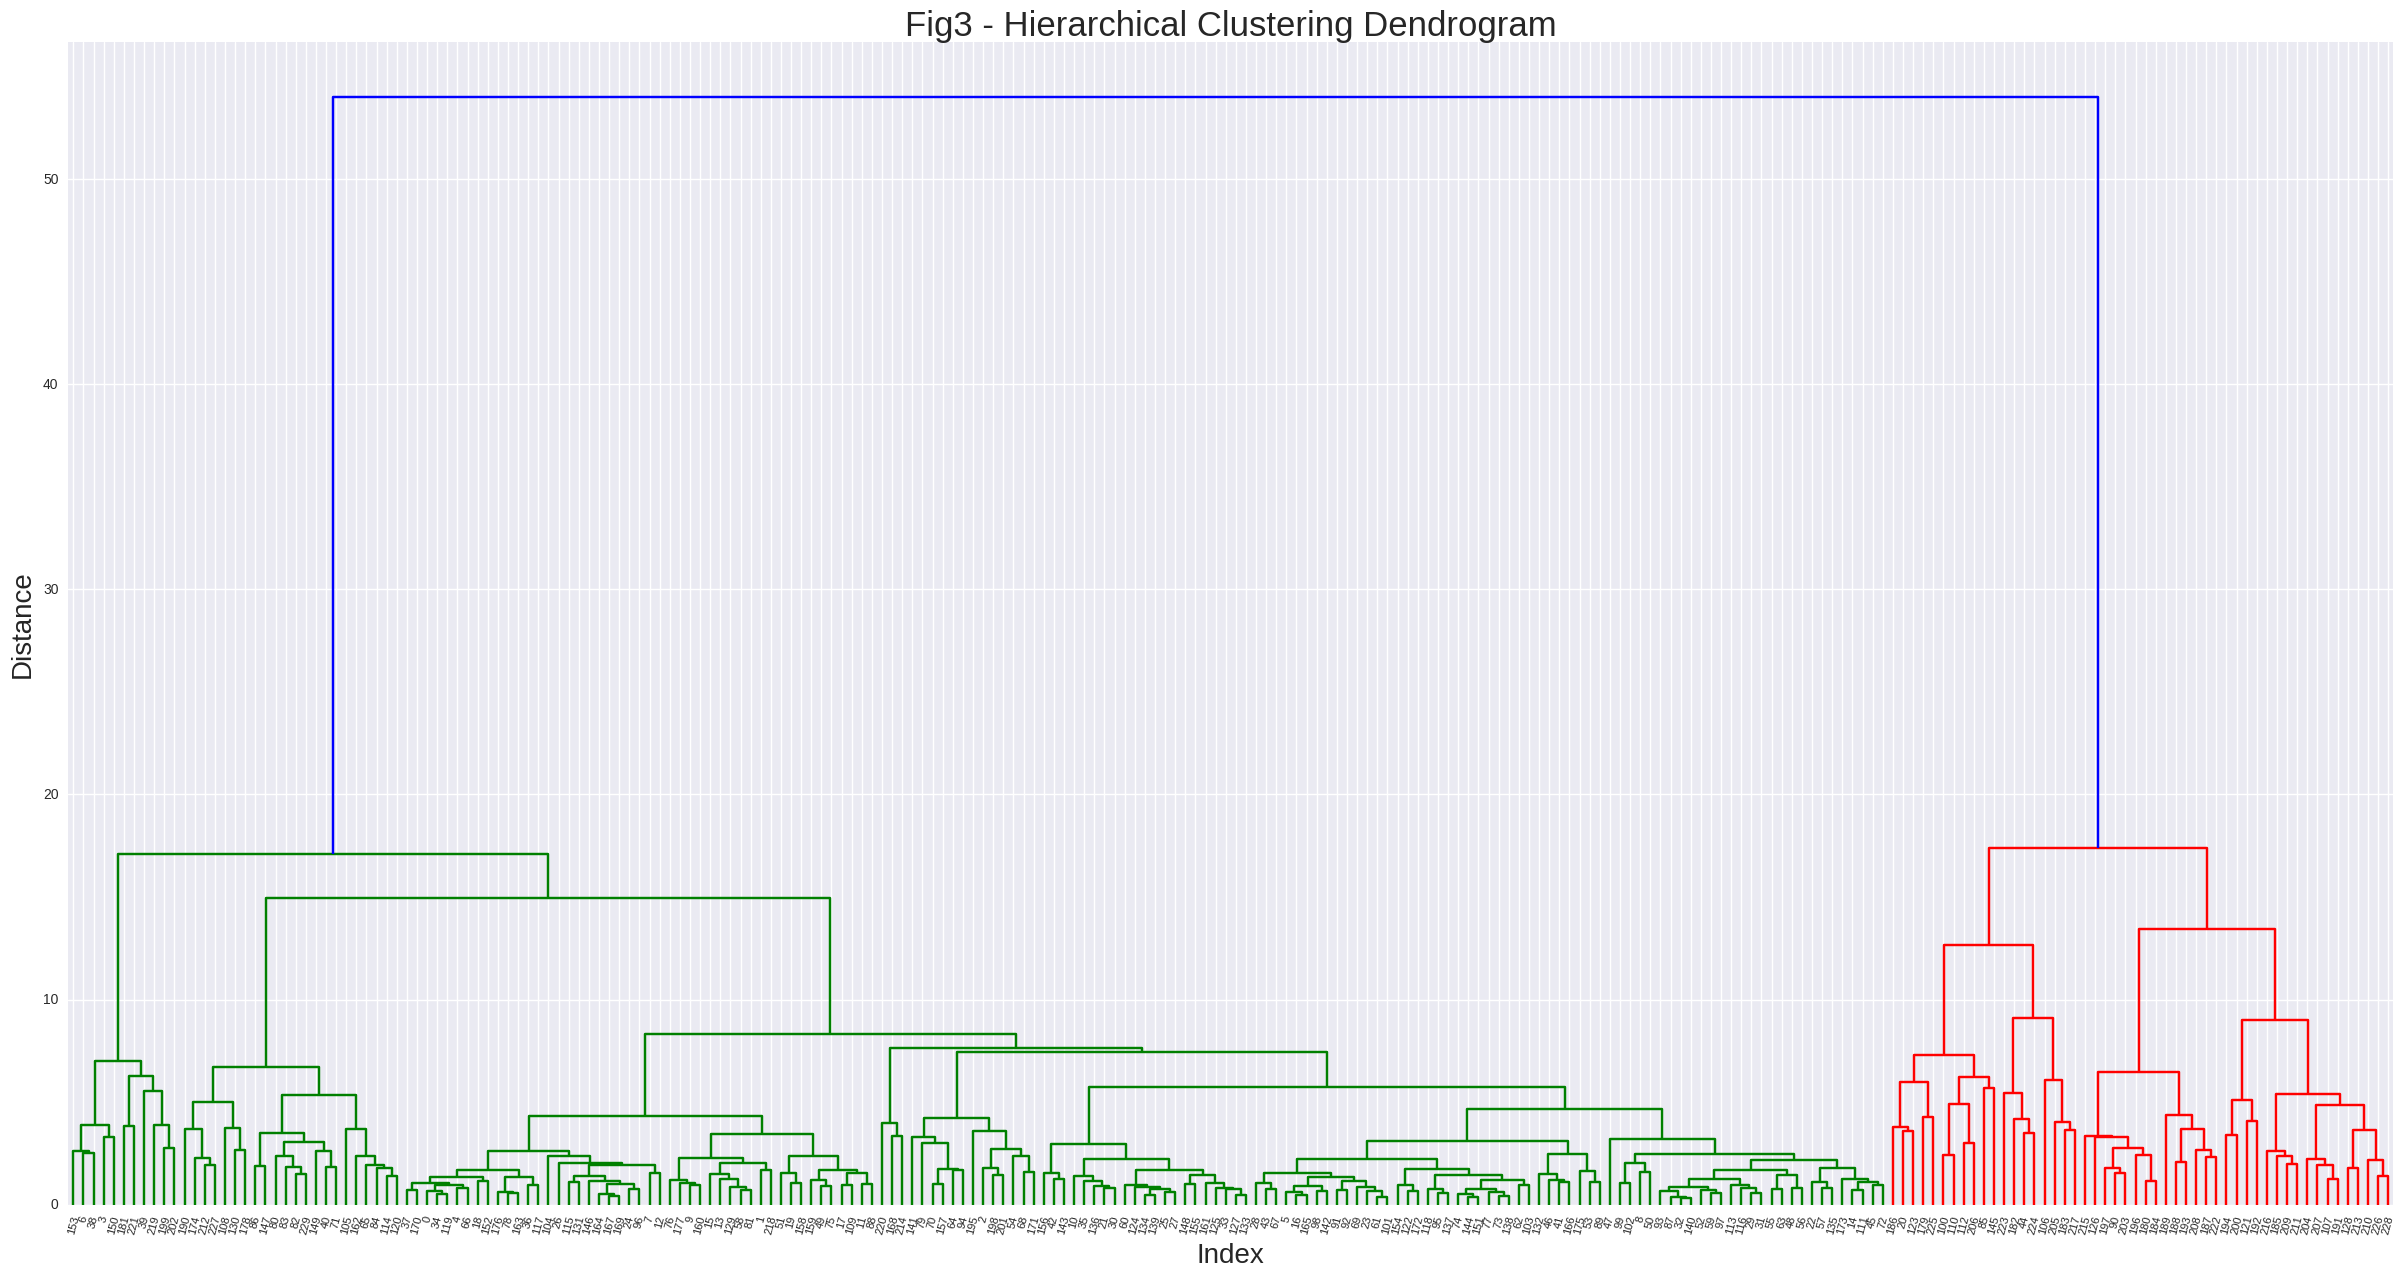

In [73]:
# Plot the Dendrogram
pl.figure(figsize(30, 15))

pl.title('Fig3 - Hierarchical Clustering Dendrogram', fontsize=25)
pl.xlabel('Index', fontsize=20)
pl.ylabel('Distance', fontsize=20)
dendrogram(Z, leaf_rotation=75, leaf_font_size=8)
pl.show()

**Figure 3**: The dendrogram demonstrates the Hierarchical clustering result. The colors provide a suggestion of a reasonable cluster numbers for the data points, which is three in this case. 

In [74]:
# cut the "tree" and label the three clusters based on the distances
hlabels = fcluster(Z, 3, criterion='maxclust')

## 7. Compare the Clusters on Map

In [75]:
CBus4 = CBus3.copy()
# Create two additional columns for clustering labels
CBus4['kmeans'] = klabels
CBus4['hccl'] = hlabels

# in case the colors on maps are not consistant, we can switch the cluster labels.
#CBus4['hccl'] = CBus4.hccl.replace([1,3],[3,1]) 

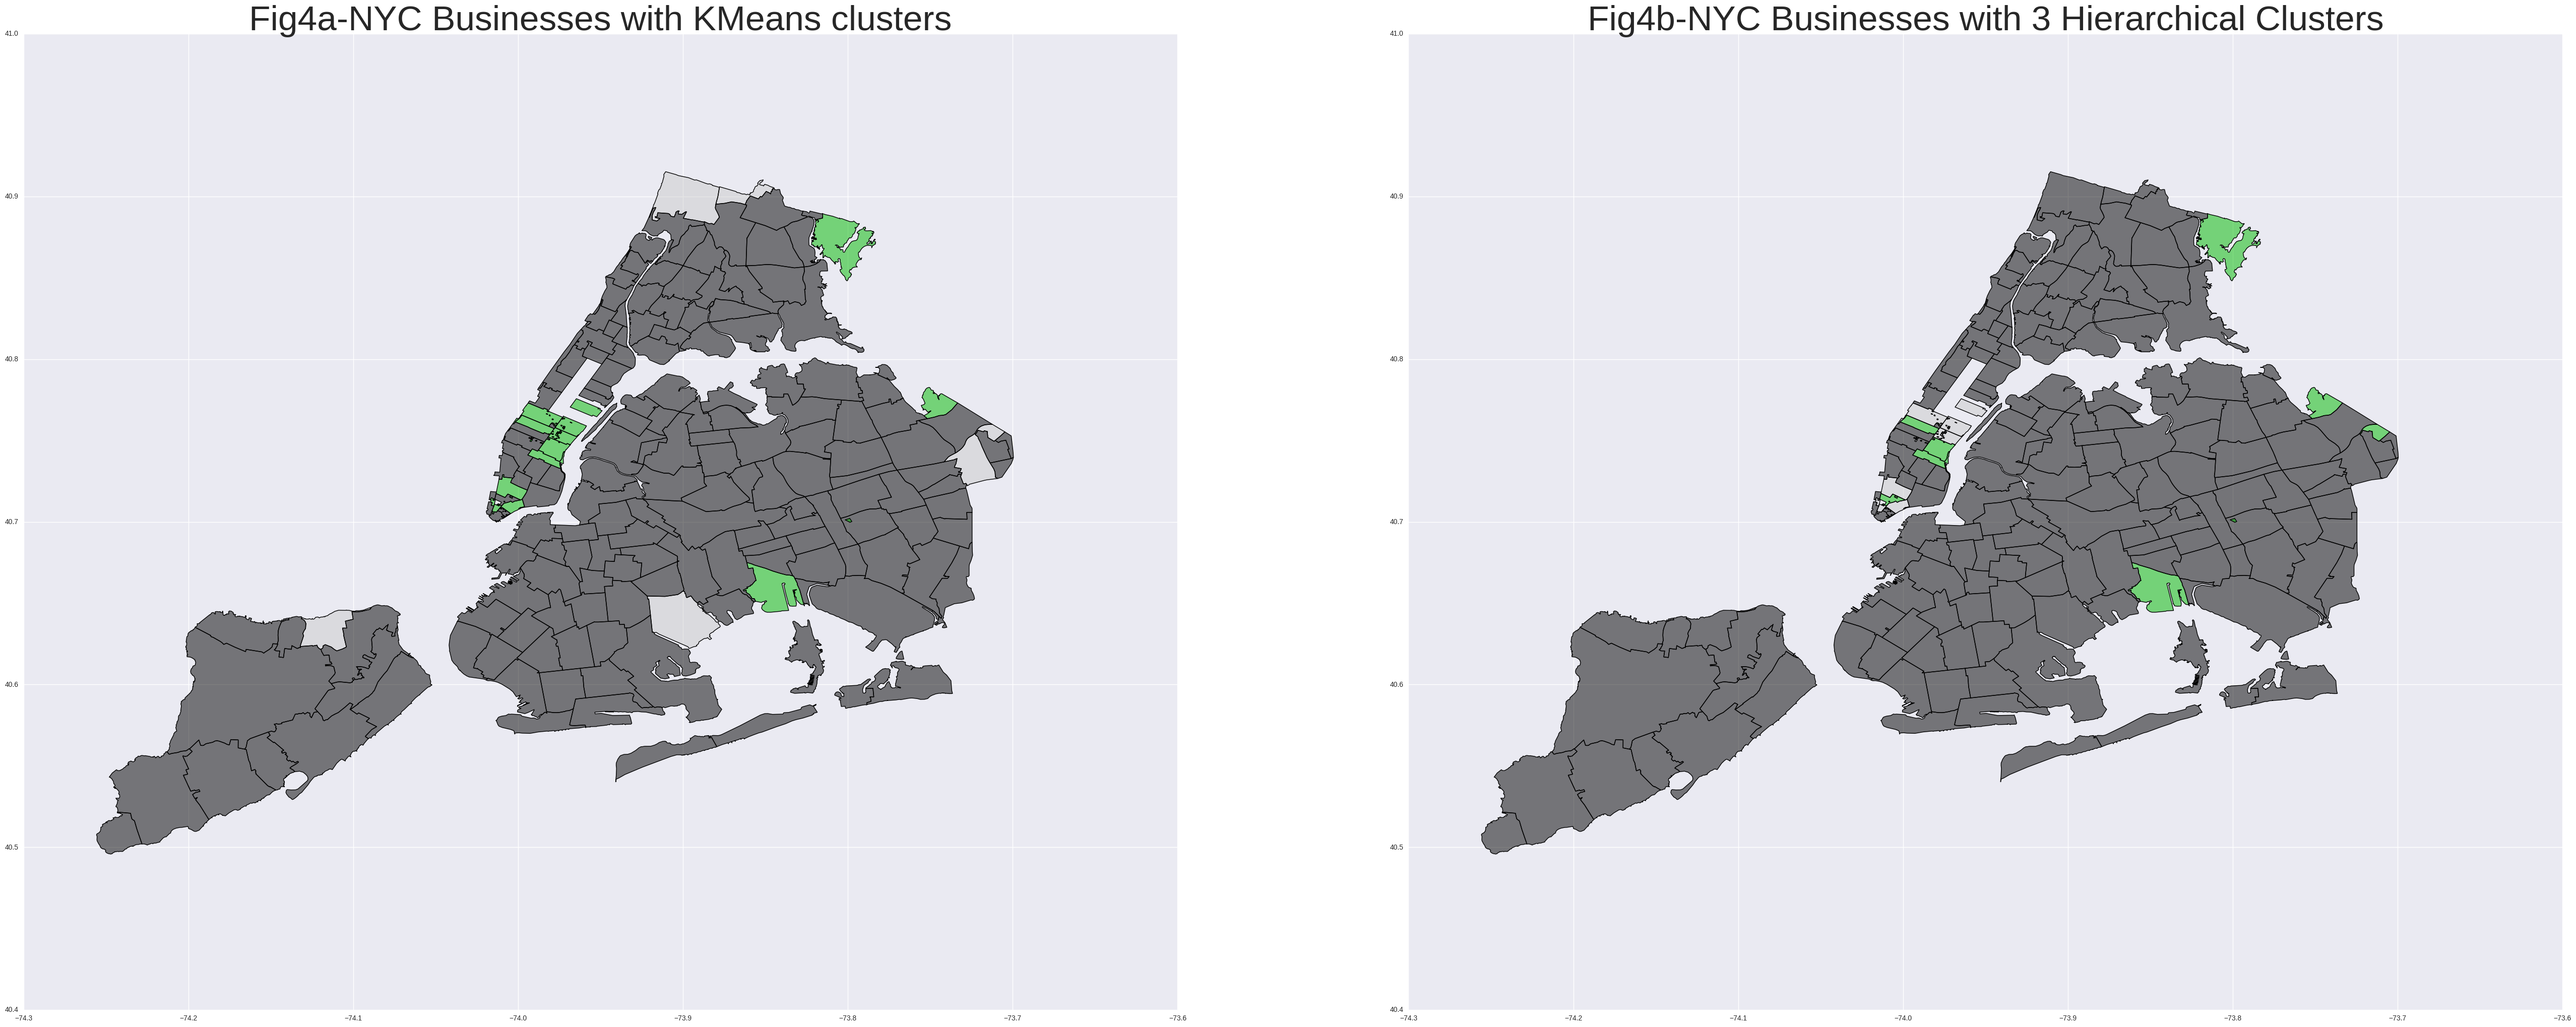

In [76]:
# Plot the maps
fig = pl.figure(figsize(65, 25))

# plot kmeans clusters on map
ax1 = fig.add_subplot(121)
CBus4.plot(cmap='spectral', column='kmeans', ax=ax1, categorical=True, k=3)
ax1.set_title('Fig4a-NYC Businesses with KMeans clusters', fontsize=50)

# plot Hierarchical clusters on map
ax2 = fig.add_subplot(122)
CBus4.plot(cmap='spectral', column='hccl', ax=ax2, categorical=True, k=3)
ax2.set_title('Fig4b-NYC Businesses with 3 Hierarchical Clusters', fontsize=50)


**Figure 4a, 4b**: The maps show the Kmeans and the Hierarchical clustering results. The three colors represent the three clusters. 

**Similarity**: The clustering patterns on both map look similar-- the majority of the area including Staten Island, Uptown and Midtown South of Manhattan, Bronx, Queens and Brooklyn are determined to be the same cluster(area in dark grey) ; north east part of Brox, a block in the north east of Brooklyn and a block in the north east of Queens are labeled the same (area in green)

**Difference**: 
1. With KMeans clustering, a block in the north of Staten Island and a block in the north west of Bronx, as well as a block in the east of Brooklyn(area in light grey) are labeled differently as the blocks in dark grey, whereas these same areas are labeled the same(all in dark grey) using the Hierarchical method. 
2. With KMeans, Midtown Manhattan and downtown Manhattan are labeled the same(area in green), however, Hierarchical determines that the same blocks belong to two different clusters(green and light grey areas) .

Further efforts needs to be made to find outliers.

### Thank You!